# Converting Deterministic Assumptions to Random Variables 

The excel model uses point assumptions for the following: 
- Rent Growth 
- Vacancy Rate 
- Interest Rate

For monte carlo simulation, these drivers are modelled as random variables with: 
- Mean (central tendency)
- Dispersion (volatility) 
- Sensible bounds 

This notebook defines distributions for 
1) Rent Growth 
2) Vacancy Rate 
3) Interest Rate Changes 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

rng = np.random.default_rng(42)

def summarize(x: np.ndarray, name: str):
    s = pd.Series(x).describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
    print(f"\{name}")
    display(s)

<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
C:\Users\trabi\AppData\Local\Temp\ipykernel_29828\2685893590.py:9: SyntaxWarning: invalid escape sequence '\{'
  print(f"\{name}")


## Rent Growth Distribution 

Annual rent growth will be modelled as a random variable. 

Mean and volatility will be estimated from historical YoY rent growth data. 

In [4]:
path = "../data/raw/abs_cpi_rents.csv"
raw = pd.read_csv(path, skiprows=1) #header row is not needed 
raw.head(20)

,Unnamed: 0,Annual (RHS) (%),Monthly (LHS) (%)
0,Sep-22,2.9,0.5
1,Oct-22,3.5,0.6
2,Nov-22,3.6,0.2
3,Dec-22,4.1,0.5
4,Jan-23,4.8,0.7
5,Feb-23,4.8,0.7
6,Mar-23,5.3,0.5
7,Apr-23,6.1,0.8
8,May-23,6.3,0.8
9,Jun-23,7.3,0.9


In [5]:
df = raw.rename(columns={raw.columns[0]: "Date","Annual (RHS) (%)": "rent_growth_yoy"})[["Date", "rent_growth_yoy"]].copy()

df["Date"] = pd.to_datetime(df["Date"], format="%b-%y", errors="coerce")

df["rent_growth_yoy"] = pd.to_numeric(df["rent_growth_yoy"], errors="coerce") / 100.0 #convert % to decimal

df = df.dropna(subset=["Date", "rent_growth_yoy"]).sort_values("Date").reset_index(drop=True)

df.head(10)

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048
5,2023-02-01,0.048
6,2023-03-01,0.053
7,2023-04-01,0.061
8,2023-05-01,0.063
9,2023-06-01,0.073


In [6]:
rent_df = df.copy()
rent_df.head()

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048


In [8]:
rent_series = rent_df["rent_growth_yoy"].dropna()
mu_rent = float(rent_series.mean()) #mean
sigma_rent = float(rent_series.std(ddof=1)) #std dev

mu_rent, sigma_rent

(0.05916216216216215, 0.014861421932704214)

In [9]:
#defining the bounds and draw samples 
rent_growth_min = -0.05
rent_growth_max = 0.15

def draw_rent_growth(n: int) -> np.ndarray:
    x = rng.normal(mu_rent,sigma_rent,size=n)
    return np.clip(x, rent_growth_min, rent_growth_max)

rent_draws = draw_rent_growth(10_000)
summarize(rent_draws, "Rent Growth Draws (Annual)")

\Rent Growth Draws (Annual)


count    10000.000000
mean         0.059010
std          0.014956
min         -0.006066
1%           0.023884
5%           0.034283
50%          0.058966
95%          0.083576
99%          0.094173
max          0.118992
dtype: float64

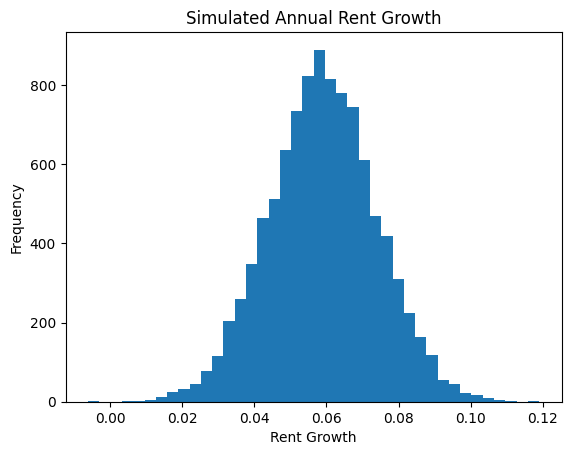

In [10]:
plt.figure()
plt.hist(rent_draws, bins=40)
plt.title("Simulated Annual Rent Growth")
plt.xlabel("Rent Growth")
plt.ylabel("Frequency")
plt.show()

## Vacancy Rate as a Random Variable 

Since vacancy rate is bounded between 0 and 1, a beta distribution will be used. 


In [13]:
vac_mean = 0.013 #model's base vacancy is 1.3%
vac_std = 0.007 #assuming std dev is 0.7%

#converting mean and std to alpha/beta for beta distribution 
var = vac_std**2
max_var = vac_mean * (1-vac_mean)
if var >= max_var: 
    raise ValueError("vac_std is too large for a beta distribution at this mean.")

alpha = vac_mean * (vac_mean*(1-vac_mean)/var -1)
beta  = (1 - vac_mean) * (vac_mean*(1 - vac_mean)/var - 1)

alpha, beta

(3.391142857142856, 257.4659999999999)

In [14]:
#draw vacancy 
def draw_vacancy(n: int) -> np.ndarray:
    return rng.beta(alpha, beta, size=n)

vac_draws = draw_vacancy(10_000)
summarize(vac_draws, "Vacancy Rate Draws")

\Vacancy Rate Draws


count    10000.000000
mean         0.013055
std          0.007064
min          0.000697
1%           0.002236
5%           0.003943
50%          0.011842
95%          0.026274
99%          0.034383
max          0.060255
dtype: float64

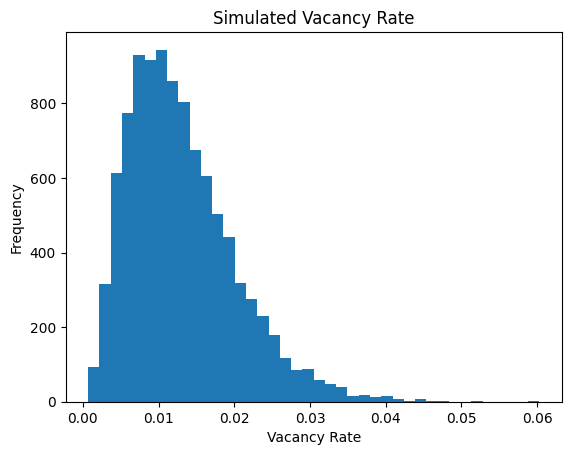

In [15]:
plt.figure()
plt.hist(vac_draws, bins=40)
plt.title("Simulated Vacancy Rate")
plt.xlabel("Vacancy Rate")
plt.ylabel("Frequency")
plt.show()

## Interest Rates as a Random Variable 


In [17]:
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx")
rba_raw.head()

,F1 INTEREST RATES AND YIELDS – MONEY MARKET,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Title,Cash Rate Target,Change in the Cash Rate Target,Interbank Overnight Cash Rate,Highest Interbank Overnight Cash Rate,Lowest Interbank Overnight Cash Rate,Volume of Cash Market Transactions,Number of Cash Market Transactions,Total Return Index,EOD 1-month BABs/NCDs,EOD 3-month BABs/NCDs,EOD 6-month BABs/NCDs,1-month OIS,3-month OIS,6-month OIS,1-month Treasury Note,3- month Treasury Note,6- month Treasury Note
1,Description,Cash Rate Target on date,Change in the Cash Rate Target (in percentage ...,Interbank Overnight Cash Rate on date,Highest Interbank Overnight Cash Rate on date,Lowest Interbank Overnight Cash Rate on date,Volume of Interbank Overnight Cash Market Tran...,Number of Interbank Overnight Cash Market Tran...,Cash Rate Total Return Index on date,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Overnight Indexed Swaps-1 month,Overnight Indexed Swaps-3 months,Overnight Indexed Swaps-6 months,Treasury Note-1 month,Treasury Note-3 month,Treasury Note-6 month
2,Frequency,Daily,as announced,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily
3,Type,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original
4,Units,Per cent,Per cent,Per cent,Per cent,Per cent,$m,Number,Index 04-Jan-2011=100,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent


In [18]:
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx", skiprows=10)
rba = rba_raw.iloc[:, [0, 1]].copy()
rba.columns = ["Date", "cash_rate"]

rba["Date"] = pd.to_datetime(rba["Date"], errors="coerce")
rba["cash_rate"] = pd.to_numeric(rba["cash_rate"], errors="coerce") / 100.0

rba = rba.dropna().sort_values("Date").reset_index(drop=True)
rba.head(20)

,Date,cash_rate
0,2011-01-04,0.0475
1,2011-01-05,0.0475
2,2011-01-06,0.0475
3,2011-01-07,0.0475
4,2011-01-10,0.0475
5,2011-01-11,0.0475
6,2011-01-12,0.0475
7,2011-01-13,0.0475
8,2011-01-14,0.0475
9,2011-01-17,0.0475


In [19]:
rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())
rba_monthly.head(20)

C:\Users\trabi\AppData\Local\Temp\ipykernel_29828\2106739903.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())


,Date,cash_rate
0,2011-01-31,0.047500
1,2011-02-28,0.047500
2,2011-03-31,0.047500
3,2011-04-30,0.047500
4,2011-05-31,0.047500
5,2011-06-30,0.047500
6,2011-07-31,0.047500
7,2011-08-31,0.047500
8,2011-09-30,0.047500
9,2011-10-31,0.047500


In [20]:
rba_monthly["Date"] = rba_monthly["Date"].dt.to_period("M").dt.to_timestamp(how="start")

In [21]:
rba_monthly

,Date,cash_rate
0,2011-01-01,0.0475
1,2011-02-01,0.0475
2,2011-03-01,0.0475
3,2011-04-01,0.0475
4,2011-05-01,0.0475
...,...,...
176,2025-09-01,0.0360
177,2025-10-01,0.0360
178,2025-11-01,0.0360
179,2025-12-01,0.0360


In [23]:
#estimating monthly changes 
rate_series = rba_monthly["cash_rate"].dropna().sort_index()

rate_change = rate_series.diff().dropna()

mu_dr = float(rate_change.mean())
sigma_dr = float(rate_change.std(ddof=1))

mu_dr, sigma_dr

(-6.388888888888887e-05, 0.0012193649477954308)

In [24]:
dr_min = -0.01
dr_max = 0.01

def draw_rate_changes(n: int) -> np.ndarray: 
    dr = rng.normal(mu_dr, sigma_dr, size=n)
    return np.clip(dr, dr_min, dr_max)

dr_draws = draw_rate_changes(10_000)
summarize(dr_draws, "Monthly Cash Rate Change Draws")

\Monthly Cash Rate Change Draws


count    10000.000000
mean        -0.000070
std          0.001221
min         -0.004828
1%          -0.002935
5%          -0.002082
50%         -0.000071
95%          0.001959
99%          0.002775
max          0.005040
dtype: float64

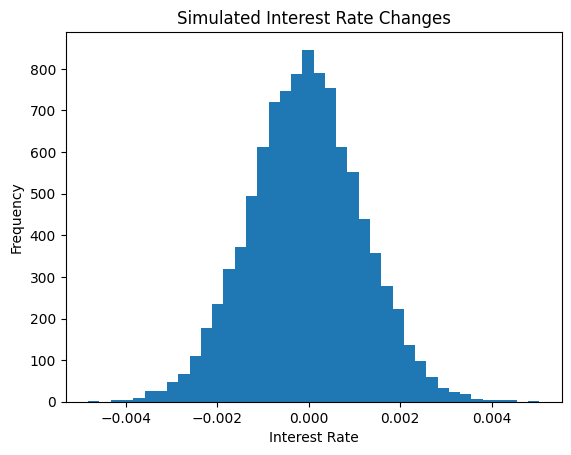

In [25]:
plt.figure()
plt.hist(dr_draws, bins=40)
plt.title("Simulated Interest Rate Changes")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.show()

Comparing the simulation distributions against excel assumptions to ensure that random variables are plausible 

In [30]:
sanity = pd.DataFrame({
    "Driver": ["Rent growth (Annual)", "Vacancy Rate", "Cash Rate Change (Monthly)"],
    "Excel Base": [0.0630,0.013, np.nan],
    "Sim Mean": [rent_draws.mean(), vac_draws.mean(),dr_draws.mean()],
    "Sim Std": [rent_draws.std(ddof=1), vac_draws.std(ddof=1), dr_draws.std(ddof=1)]
})

sanity

,Driver,Excel Base,Sim Mean,Sim Std
0,Rent growth (Annual),0.063,0.059010,0.014956
1,Vacancy Rate,0.013,0.013055,0.007064
2,Cash Rate Change (Monthly),NaN,-0.000070,0.001221


The excel model represents the base case expectation, while the monte carlo simulation introduces volatility around the base case to assess downside and tail risk 